In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display
from sklearn.metrics import ConfusionMatrixDisplay

from nlp_adversarial_attacks.utils.file_io import load_json

In [2]:
def extract_infos(metrics_path):
    parts = metrics_path.parts
    infos = {
        "target_dataset": parts[-7],
        "target_model": parts[-6],
        "embeddings": parts[-5],
        "setting": parts[-4],
        "classification_model": parts[-3],
        "feature_setting": parts[-2],
    }
    expe_json = load_json(Path(metrics_path.parents[2], "settings.json"))
    assert infos["target_dataset"] == expe_json["target_dataset"]
    assert infos["target_model"] == expe_json["target_model"]
    assert infos["embeddings"] == expe_json["embeddings_name"]
    assert infos["setting"] == expe_json["setting"]
    infos["is_binary"] = expe_json["is_binary"]

    return infos

In [3]:
all_experiments_dir = Path("data_tcab/detection-experiments/")

df_list = []
for metrics_path in all_experiments_dir.glob("**/metrics.json"):
    print(metrics_path)
    infos = extract_infos(metrics_path)
    metrics = load_json(metrics_path)
    infos.update(metrics)
    df_list.append(infos)

df = pd.DataFrame(df_list)

data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LGB\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert+tp\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\LR\bert+tp+lm\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\RF\all\metrics.json
data_tcab\detection-experiments\allocine\distilcamembert\default\clean_vs_all\RF\bert\metr

In [4]:
for column in df.columns:
    if "confusion_matrix" in column:
        df[column] = df[column].apply(lambda x: np.array(x))

In [5]:
df.sample(3)

,target_dataset,target_model,embeddings,setting,classification_model,feature_setting,is_binary,train_accuracy,train_balanced_accuracy,train_confusion_matrix,...,test_recall,test_precision,test_f1_score,test_roc_auc,best_params,classes_labels,important_features,feature_names,coef,intercept
3,allocine,distilcamembert,default,clean_vs_all,LGB,bert+tp+lm,True,0.936543,0.936543,"[[5132, 226], [454, 4904]]",...,0.714286,0.701559,0.707865,0.790443,None,"[clean, perturbed]",None,"[lm_perplexity_region0, lm_perplexity_region1,...",None,None
14,allocine,distilcamembert,default,multiclass_with_clean,LGB,bert+tp,False,0.969290,0.971997,"[[739, 5, 0, 0, 5, 2, 0], [17, 1123, 1, 3, 13,...",...,NaN,NaN,NaN,NaN,None,"[bae, clean, deepwordbug, input_reduction, pww...",None,"[avg_word_length_mean_region0, avg_word_length...",None,None
16,allocine,distilcamembert,default,multiclass_with_clean,LR,all,False,0.993888,0.994282,"[[750, 0, 0, 0, 0, 0, 1], [0, 1186, 0, 1, 0, 0...",...,NaN,NaN,NaN,NaN,None,"[bae, clean, deepwordbug, input_reduction, pww...",None,"[lm_perplexity_region0, lm_perplexity_region1,...",{'bae': {'lm_perplexity_region0': 0.0998374113...,None


In [6]:
df.columns

Index(['target_dataset', 'target_model', 'embeddings', 'setting',
       'classification_model', 'feature_setting', 'is_binary',
       'train_accuracy', 'train_balanced_accuracy', 'train_confusion_matrix',
       'train_recall', 'train_precision', 'train_f1_score', 'train_roc_auc',
       'validation_accuracy', 'validation_balanced_accuracy',
       'validation_confusion_matrix', 'validation_recall',
       'validation_precision', 'validation_f1_score', 'validation_roc_auc',
       'test_accuracy', 'test_balanced_accuracy', 'test_confusion_matrix',
       'test_recall', 'test_precision', 'test_f1_score', 'test_roc_auc',
       'best_params', 'classes_labels', 'important_features', 'feature_names',
       'coef', 'intercept'],
      dtype='object')

In [7]:
COLUMNS_ORDER = {
    "embeddings": ["default", "fr+small"],
    "setting": ["clean_vs_all", "multiclass_with_clean"],
    "feature_setting": ["bert", "bert+tp", "bert+tp+lm", "all"],
    "classification_model": ["LR", "RF", "LGB"],
}

In [8]:
COLUMNS_KEY = {}


def sort_function(order_list):
    return lambda serie: serie.map(lambda x: order_list.index(x))


for column in COLUMNS_ORDER:
    assert set(df[column]) == set(COLUMNS_ORDER[column])
    COLUMNS_KEY[column] = sort_function(COLUMNS_ORDER[column])

COLUMNS_KEY

{'embeddings': <function __main__.sort_function.<locals>.<lambda>(serie)>,
 'setting': <function __main__.sort_function.<locals>.<lambda>(serie)>,
 'feature_setting': <function __main__.sort_function.<locals>.<lambda>(serie)>,
 'classification_model': <function __main__.sort_function.<locals>.<lambda>(serie)>}

## Table

In [9]:
def display_tables(transpose=False):
    for column in COLUMNS_ORDER.keys():
        display(HTML(f"<h3>{column}<h3/>"))
        df_temp = df.groupby(column).mean(numeric_only=True).drop(columns=["is_binary"])
        df_temp = df_temp.sort_index(key=COLUMNS_KEY[column])
        if transpose:
            df_temp = df_temp.transpose()
            df_temp.index.name = "feature"
            gradient_axis = 1
        else:
            gradient_axis = 0
        df_temp_style = df_temp.style.background_gradient(
            cmap="RdYlGn", axis=gradient_axis
        )
        display(df_temp_style)

In [10]:
display_tables(transpose=False)

,train_accuracy,train_balanced_accuracy,train_recall,train_precision,train_f1_score,train_roc_auc,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1_score,test_roc_auc
embeddings,,,,,,,,,,,,,,,,,,
default,0.815579,0.817195,0.840488,0.873089,0.855775,0.861220,0.662748,0.650638,0.705615,0.806191,0.750193,0.772427,0.668612,0.646730,0.713719,0.656630,0.683455,0.773816
fr+small,0.858484,0.856248,0.900865,0.918359,0.909007,0.911200,0.727556,0.710159,0.811586,0.867687,0.837511,0.844558,0.762467,0.693595,0.789777,0.748503,0.767311,0.836091


,train_accuracy,train_balanced_accuracy,train_recall,train_precision,train_f1_score,train_roc_auc,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1_score,test_roc_auc
setting,,,,,,,,,,,,,,,,,,
clean_vs_all,0.886210,0.886210,0.870676,0.895724,0.882391,0.886210,0.808493,0.808493,0.758600,0.836939,0.793852,0.808493,0.825695,0.804954,0.751748,0.702566,0.725383,0.804954
multiclass_with_clean,0.787853,0.787233,nan,nan,nan,nan,0.581811,0.552304,nan,nan,nan,nan,0.605385,0.535371,nan,nan,nan,nan


,train_accuracy,train_balanced_accuracy,train_recall,train_precision,train_f1_score,train_roc_auc,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1_score,test_roc_auc
feature_setting,,,,,,,,,,,,,,,,,,
bert,0.779289,0.781550,0.823099,0.846038,0.833830,0.838715,0.603871,0.590143,0.659449,0.762308,0.705826,0.728909,0.613110,0.585539,0.649282,0.596744,0.620733,0.726458
bert+tp,0.808352,0.808845,0.818558,0.863242,0.839728,0.846040,0.657887,0.645876,0.679415,0.798571,0.732668,0.755015,0.644587,0.634154,0.671769,0.632577,0.650556,0.748818
bert+tp+lm,0.835545,0.833064,0.850224,0.899348,0.873707,0.878297,0.702430,0.685827,0.742876,0.849278,0.792118,0.805727,0.731321,0.671114,0.738284,0.714096,0.725404,0.803189
all,0.924940,0.923427,0.990824,0.974267,0.982298,0.981787,0.816419,0.799747,0.952662,0.937599,0.944796,0.944319,0.873141,0.789843,0.947657,0.866850,0.904840,0.941350


,train_accuracy,train_balanced_accuracy,train_recall,train_precision,train_f1_score,train_roc_auc,validation_accuracy,validation_balanced_accuracy,validation_recall,validation_precision,validation_f1_score,validation_roc_auc,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1_score,test_roc_auc
classification_model,,,,,,,,,,,,,,,,,,
LR,0.863085,0.865173,0.869634,0.891251,0.880248,0.882395,0.731308,0.719290,0.785574,0.846187,0.814224,0.823397,0.717810,0.704910,0.772817,0.715401,0.742643,0.817127
RF,0.678822,0.674888,0.784668,0.834254,0.807372,0.816524,0.637037,0.625163,0.739806,0.804051,0.768378,0.783781,0.680971,0.618351,0.741638,0.658326,0.696742,0.785484
LGB,0.969188,0.970103,0.957727,0.961667,0.959553,0.959710,0.717110,0.696742,0.750422,0.860578,0.798954,0.818300,0.747838,0.687227,0.740788,0.733972,0.736765,0.812249


In [11]:
display_tables(transpose=True)

embeddings,default,fr+small
feature,,
train_accuracy,0.815579,0.858484
train_balanced_accuracy,0.817195,0.856248
train_recall,0.840488,0.900865
train_precision,0.873089,0.918359
train_f1_score,0.855775,0.909007
train_roc_auc,0.861220,0.911200
validation_accuracy,0.662748,0.727556
validation_balanced_accuracy,0.650638,0.710159
validation_recall,0.705615,0.811586


setting,clean_vs_all,multiclass_with_clean
feature,,
train_accuracy,0.886210,0.787853
train_balanced_accuracy,0.886210,0.787233
train_recall,0.870676,nan
train_precision,0.895724,nan
train_f1_score,0.882391,nan
train_roc_auc,0.886210,nan
validation_accuracy,0.808493,0.581811
validation_balanced_accuracy,0.808493,0.552304
validation_recall,0.758600,nan


feature_setting,bert,bert+tp,bert+tp+lm,all
feature,,,,
train_accuracy,0.779289,0.808352,0.835545,0.924940
train_balanced_accuracy,0.781550,0.808845,0.833064,0.923427
train_recall,0.823099,0.818558,0.850224,0.990824
train_precision,0.846038,0.863242,0.899348,0.974267
train_f1_score,0.833830,0.839728,0.873707,0.982298
train_roc_auc,0.838715,0.846040,0.878297,0.981787
validation_accuracy,0.603871,0.657887,0.702430,0.816419
validation_balanced_accuracy,0.590143,0.645876,0.685827,0.799747
validation_recall,0.659449,0.679415,0.742876,0.952662


classification_model,LR,RF,LGB
feature,,,
train_accuracy,0.863085,0.678822,0.969188
train_balanced_accuracy,0.865173,0.674888,0.970103
train_recall,0.869634,0.784668,0.957727
train_precision,0.891251,0.834254,0.961667
train_f1_score,0.880248,0.807372,0.959553
train_roc_auc,0.882395,0.816524,0.959710
validation_accuracy,0.731308,0.637037,0.717110
validation_balanced_accuracy,0.719290,0.625163,0.696742
validation_recall,0.785574,0.739806,0.750422


## Scatter plot

In [12]:
def scatter_plot(df, ax_column, x_column, color_column, metric):
    fig, axes = plt.subplots(
        1, len(COLUMNS_ORDER[ax_column]), figsize=(4 * len(COLUMNS_ORDER[ax_column]), 3)
    )
    for i, ax_modality in enumerate(COLUMNS_ORDER[ax_column]):
        sns.stripplot(
            data=df[df[ax_column] == ax_modality],
            x=x_column,
            y=metric,
            hue=color_column,
            order=COLUMNS_ORDER[x_column],
            ax=axes[i],
        )
        axes[i].set_title(ax_modality)

    for ax in axes:
        ax.set_ylim(0.2, 1)
        ax.grid(axis="y")

    plt.show()


def scatter_plot_loop(df, loop_column, ax_column, x_column, color_column, metric):
    for name, df_group in df.groupby(loop_column):
        display(HTML(f"<h3>{loop_column} = {name}<h3/>"))
        scatter_plot(df_group, ax_column, x_column, color_column, metric)

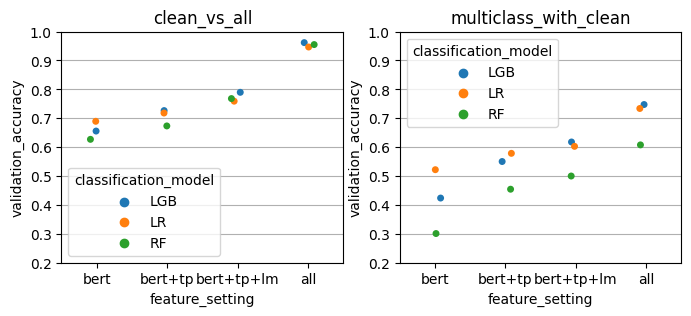

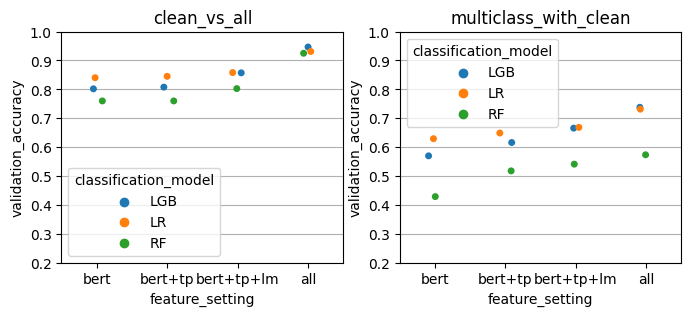

In [13]:
scatter_plot_loop(
    df,
    loop_column="embeddings",
    ax_column="setting",
    x_column="feature_setting",
    color_column="classification_model",
    metric="validation_accuracy",
)

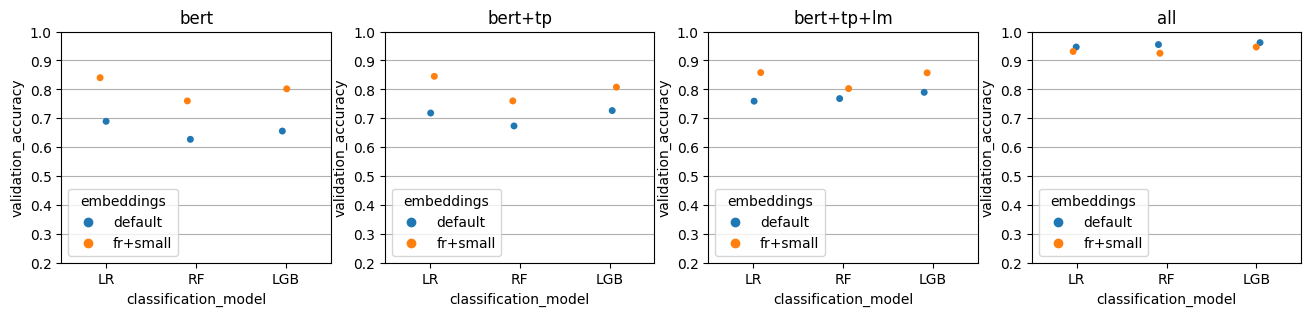

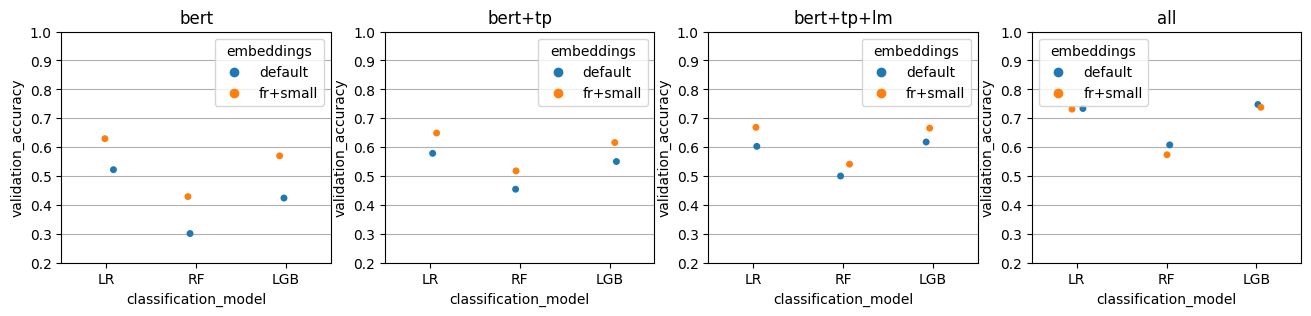

In [14]:
scatter_plot_loop(
    df,
    loop_column="setting",
    ax_column="feature_setting",
    x_column="classification_model",
    color_column="embeddings",
    metric="validation_accuracy",
)

## Confusion matrix

In [16]:
df["classes_labels"] = df["classes_labels"].apply(lambda x: tuple(x))
assert (df.groupby("is_binary")["classes_labels"].nunique() == 1).all()

In [18]:
BINARY_CLASSES = df[df["is_binary"]].iloc[0]["classes_labels"]
MULTI_CLASSES = df[~df["is_binary"]].iloc[0]["classes_labels"]

In [19]:
def plot_confusion_matrix_serie(serie, title=""):
    if serie[0].shape[0] == 2:
        classes = BINARY_CLASSES
        figsize = (4 * len(serie), 4)
        xticks_rotation = False
    else:
        classes = MULTI_CLASSES
        figsize = (6 * len(serie), 6.5)
        xticks_rotation = True
    fig, axes = plt.subplots(1, len(serie), figsize=figsize)
    for i, (index, cm) in enumerate(serie.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
        disp.plot(ax=axes[i], colorbar=False, cmap="Blues")
        axes[i].set_title(index)
        xlabels = axes[i].get_xticklabels()
        if xticks_rotation:
            axes[i].set_xticklabels(
                xlabels, rotation=40, ha="right", rotation_mode="anchor"
            )
    plt.tight_layout()
    fig.suptitle(title)
    plt.show()

In [20]:
groupby_column = "feature_setting"
cm_serie = (
    df[df.setting == "clean_vs_all"]
    .groupby(groupby_column)["validation_confusion_matrix"]
    .mean()
    .sort_index(key=COLUMNS_KEY[groupby_column])
)
cm_serie

feature_setting
bert                         [[1419.5, 358.5], [605.5, 1172.5]]
bert+tp       [[1476.8333333333333, 301.1666666666667], [570...
bert+tp+lm    [[1544.3333333333333, 233.66666666666666], [45...
all           [[1664.1666666666667, 113.83333333333333], [84...
Name: validation_confusion_matrix, dtype: object

In [21]:
def select_df(*column_modality_list):
    description = []
    df_temp = df.copy()
    for column, modality in column_modality_list:
        description.append(f"{column} = {modality}")
        df_temp = df_temp[df_temp[column] == modality]
    description = ", ".join(description)
    display(HTML(f"<h3>- {description}<h3/>"))
    return df_temp

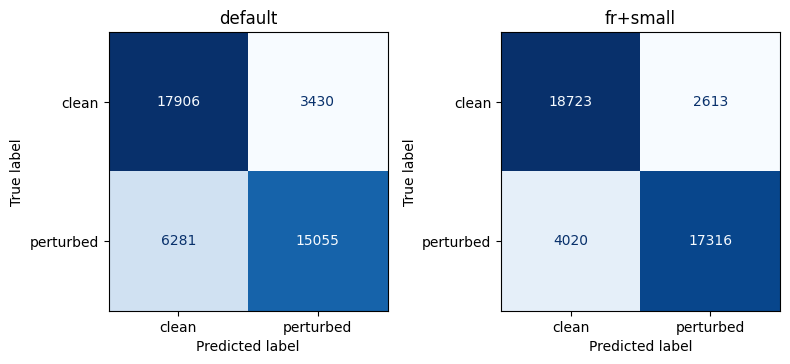

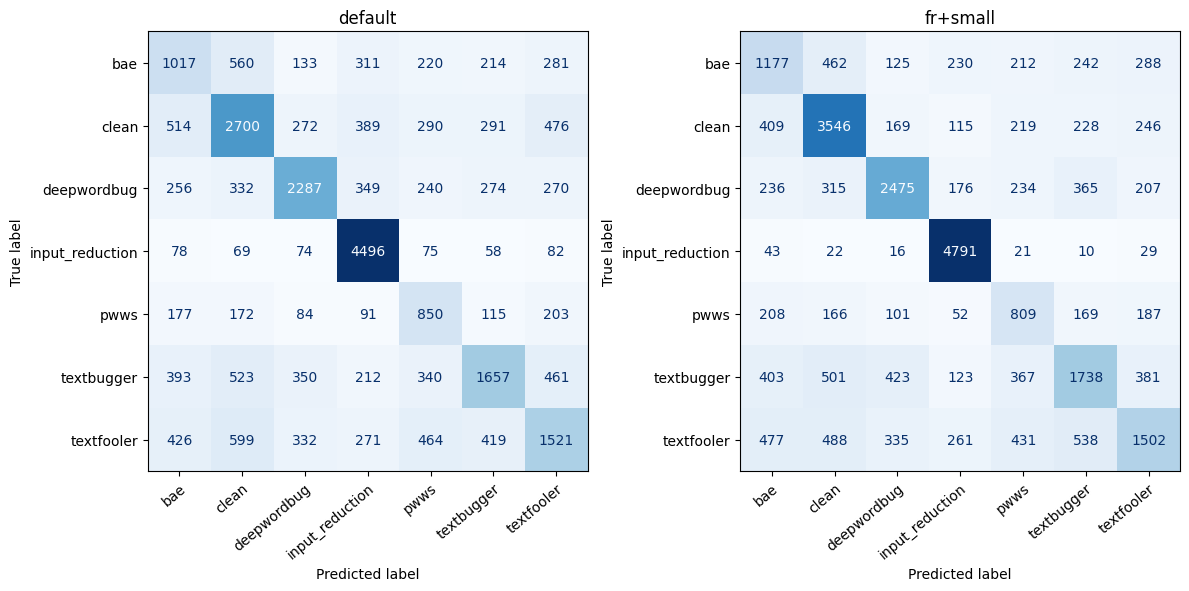

In [22]:
column1 = "setting"
column_groupby = "embeddings"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_df((column1, modality1))
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

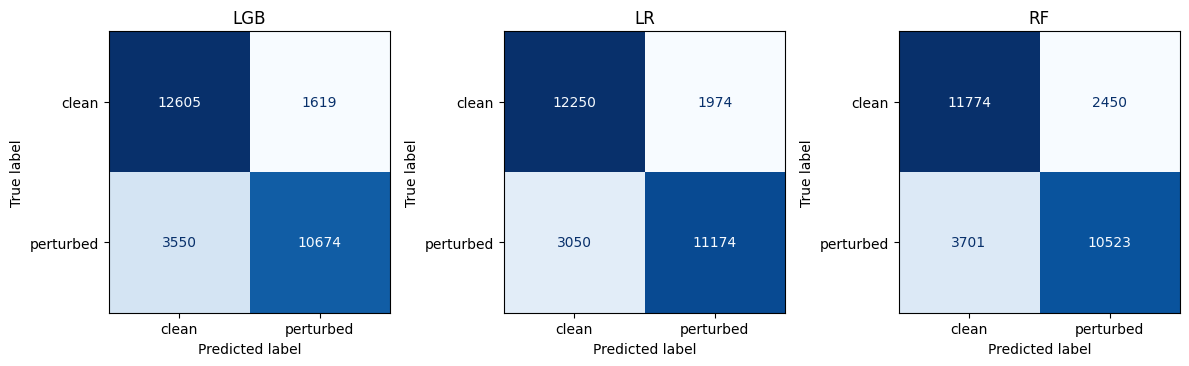

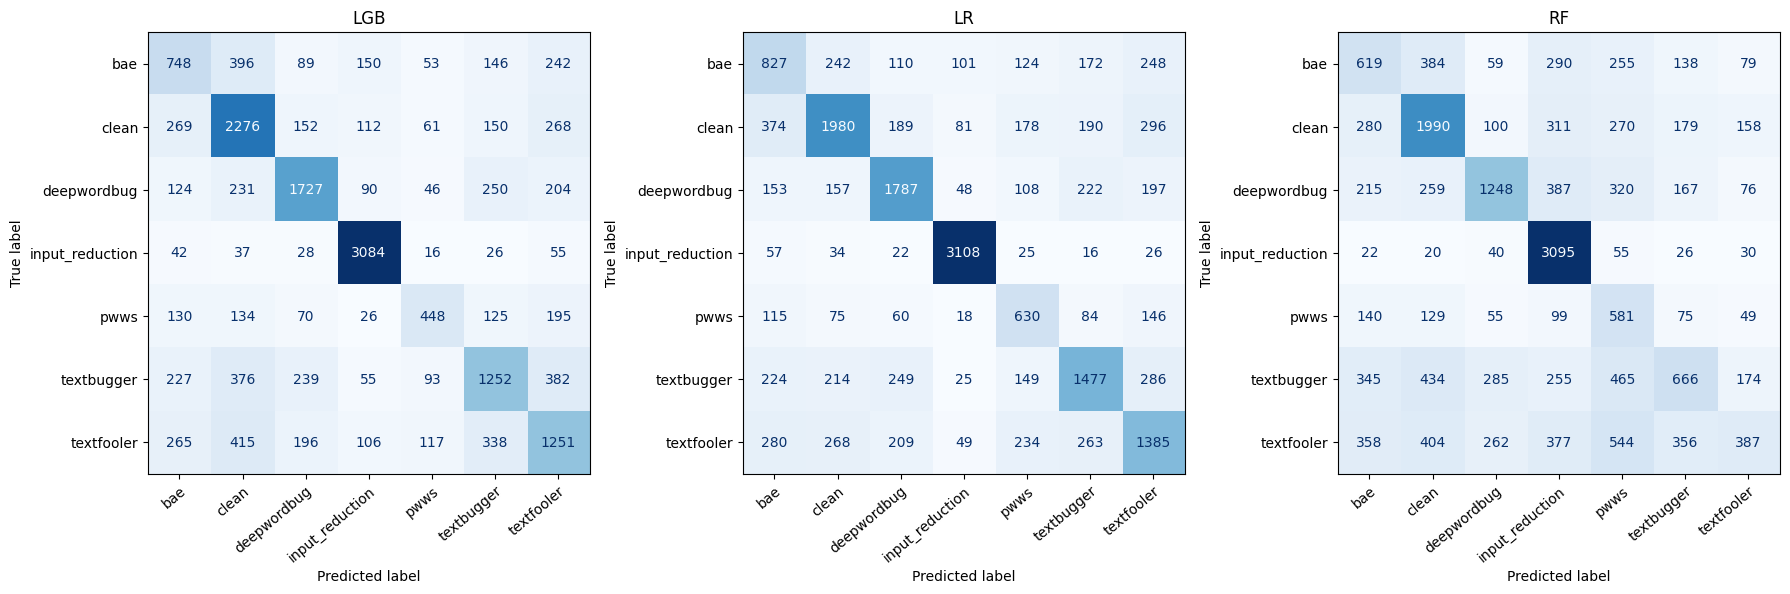

In [23]:
column1 = "setting"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_df((column1, modality1))
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

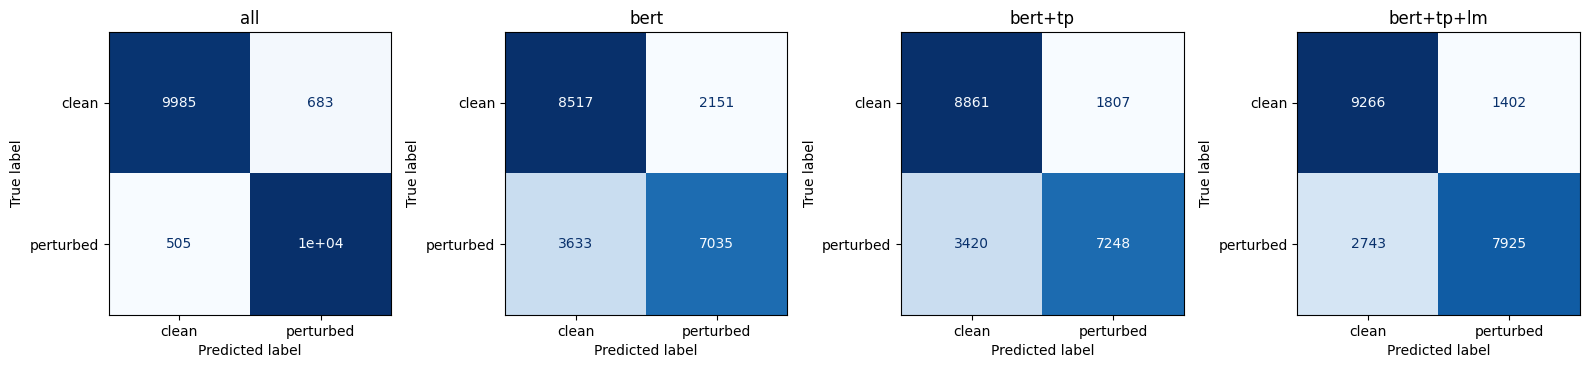

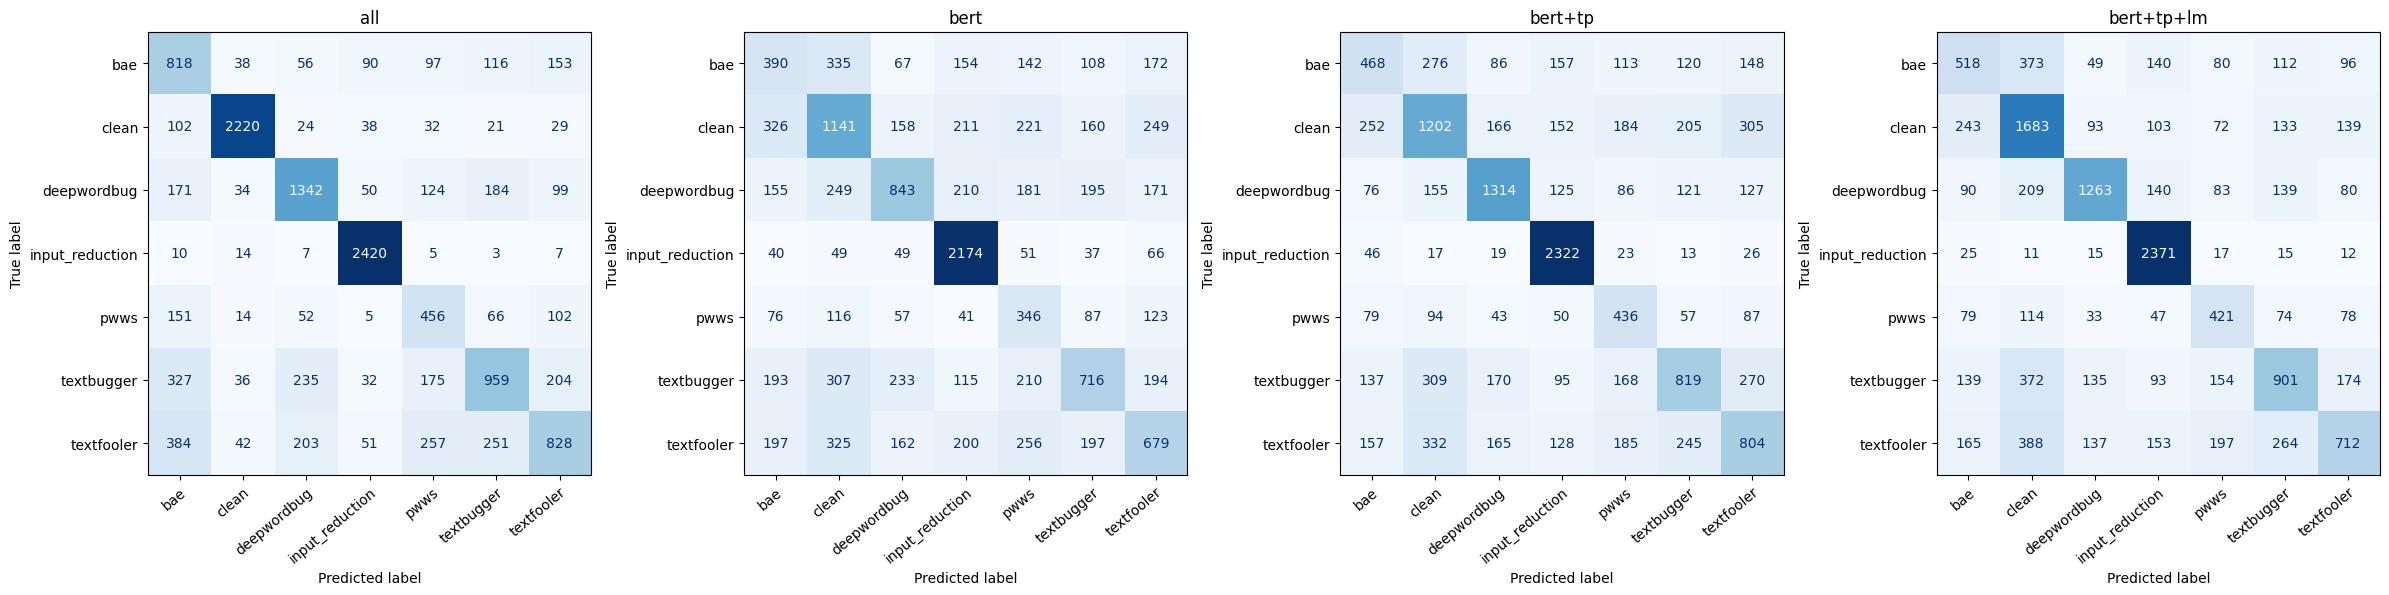

In [24]:
column1 = "setting"
column_groupby = "feature_setting"

for modality1 in COLUMNS_ORDER[column1]:
    cm_serie = (
        select_df((column1, modality1))
        .groupby(column_groupby)["validation_confusion_matrix"]
        .sum()
    )
    plot_confusion_matrix_serie(cm_serie)

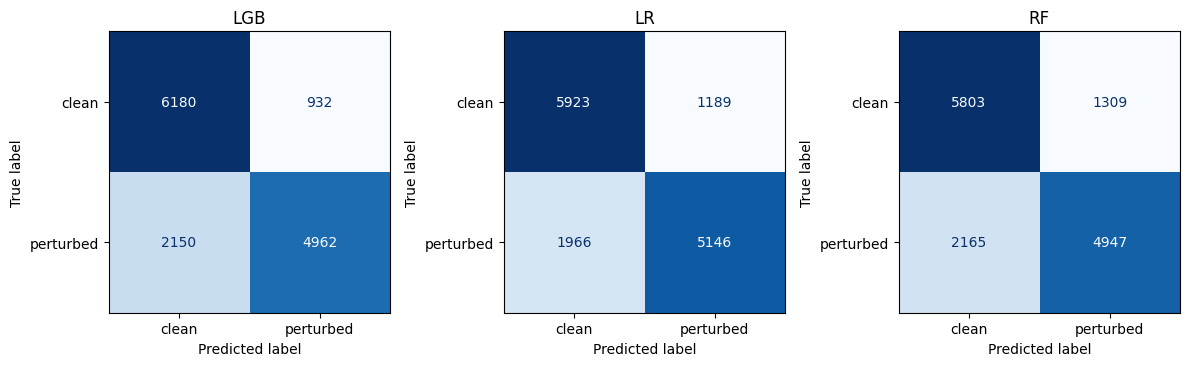

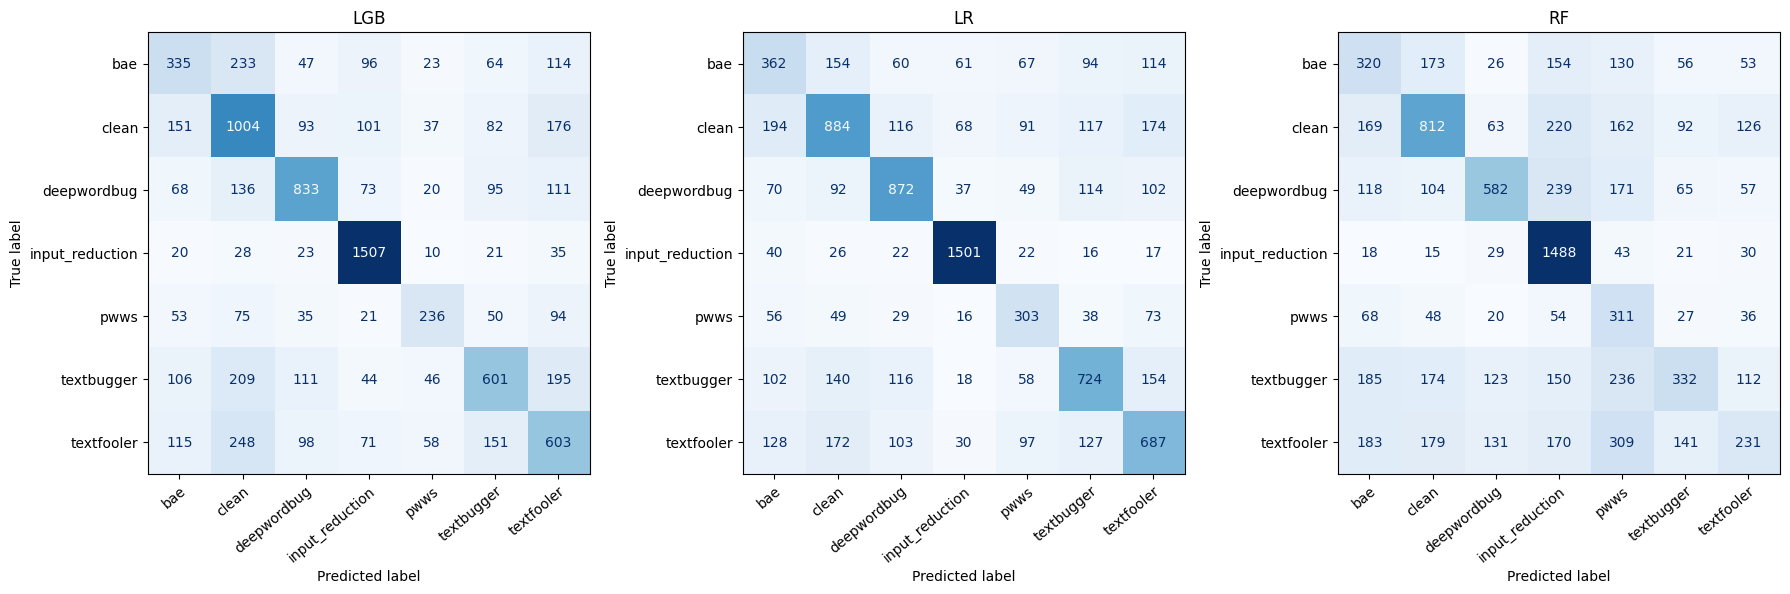

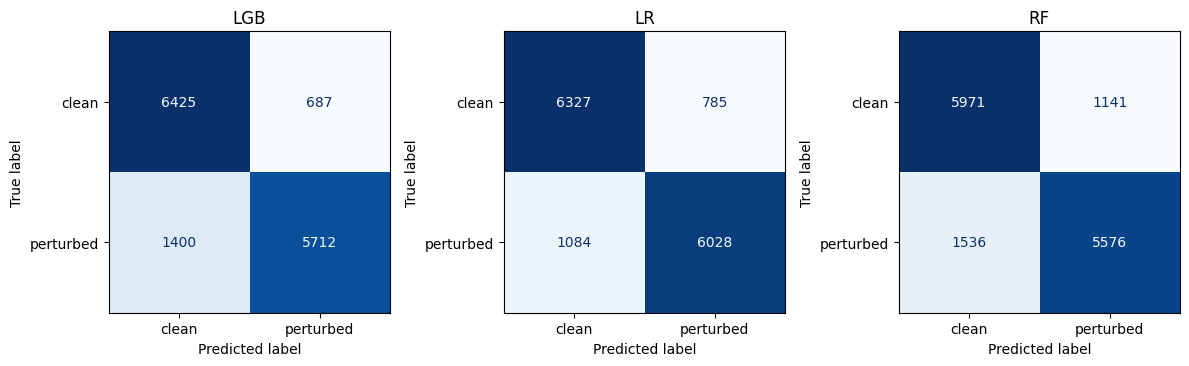

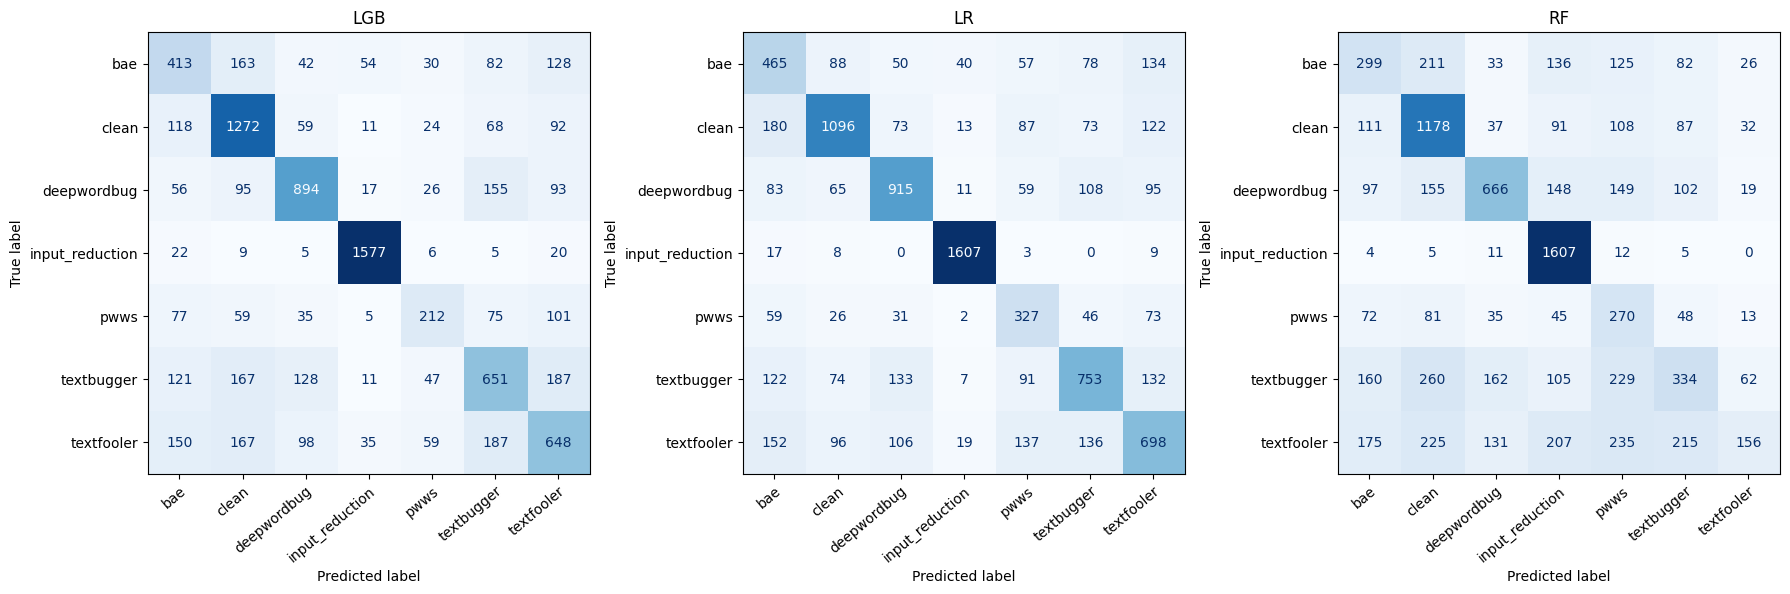

In [25]:
column1 = "embeddings"
column2 = "setting"
column_groupby = "classification_model"

for modality1 in COLUMNS_ORDER[column1]:
    for modality2 in COLUMNS_ORDER[column2]:
        cm_serie = (
            select_df((column1, modality1), (column2, modality2))
            .groupby(column_groupby)["validation_confusion_matrix"]
            .sum()
        )
        plot_confusion_matrix_serie(cm_serie)

## Logistic regression coef

In [26]:
df_temp = df[df["classification_model"] == "LR"]

In [27]:
pd.DataFrame(df_temp.iloc[0].coef)

,perturbed
avg_word_length_mean_region0,0.096602
avg_word_length_mean_region1,0.090297
avg_word_length_mean_region2,0.153790
avg_word_length_mean_region3,0.116761
avg_word_length_quant0_region0,0.324806
...,...
tm_simple_gradient_saliency_mean,-0.040531
tm_simple_gradient_saliency_quant0,0.034444
tm_simple_gradient_saliency_quant1,-0.197965
tm_simple_gradient_saliency_quant2,0.052522
